In [ ]:
# Cài đặt các thư viện cần thiết
!pip install rasterio matplotlib tqdm scikit-learn arcgis catboost lightgbm xgboost
!pip install numpy==2.0.2



  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does n

In [ ]:
# Mount Google Drive để truy cập dữ liệu
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn đến thư mục chứa dữ liệu Thanh Hóa trên Drive
data_dir = '/content/drive/MyDrive/ThanhHoa'  # Thư mục chứa dữ liệu
model_path = '/content/drive/MyDrive/ThanhHoa/voting_classifier_model.pkl'  # Đường dẫn đến model

# Kiểm tra model
import os
if os.path.exists(model_path):
    print(f"Model tồn tại tại: {model_path}")
else:
    print(f"Không tìm thấy model tại: {model_path}")
    print("Vui lòng kiểm tra lại đường dẫn!")

# Tìm tất cả các file Sentinel-2
import glob
sentinel_files = glob.glob(os.path.join(data_dir, "*.tif"))
print(f"\nTìm thấy {len(sentinel_files)} file ảnh Sentinel-2:")
for file in sentinel_files[:5]:  # Chỉ hiển thị 5 file đầu tiên nếu có nhiều file
    print(f" - {os.path.basename(file)}")

if len(sentinel_files) > 5:
    print(f"... và {len(sentinel_files) - 5} file khác.")

# Nếu không tìm thấy file nào, kiểm tra nội dung thư mục
if len(sentinel_files) == 0:
    print("\nKiểm tra nội dung thư mục:")
    !ls -la "{data_dir}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model tồn tại tại: /content/drive/MyDrive/ThanhHoa/voting_classifier_model.pkl

Tìm thấy 16 file ảnh Sentinel-2:
 - Sentinel2_ThanhHoa-0000000000-0000000000.tif
 - Sentinel2_ThanhHoa-0000000000-0000004608.tif
 - Sentinel2_ThanhHoa-0000000000-0000009216.tif
 - Sentinel2_ThanhHoa-0000000000-0000013824.tif
 - Sentinel2_ThanhHoa-0000004608-0000000000.tif
... và 11 file khác.



Thông tin file ảnh mẫu:
Tên file: Sentinel2_ThanhHoa-0000000000-0000000000.tif
Kích thước: 4608 x 4608 pixels
Số kênh: 26
Hệ tọa độ: EPSG:4326
Geotransform: | 0.00, 0.00, 104.44|
| 0.00,-0.00, 20.67|
| 0.00, 0.00, 1.00|
Kiểu dữ liệu: float64


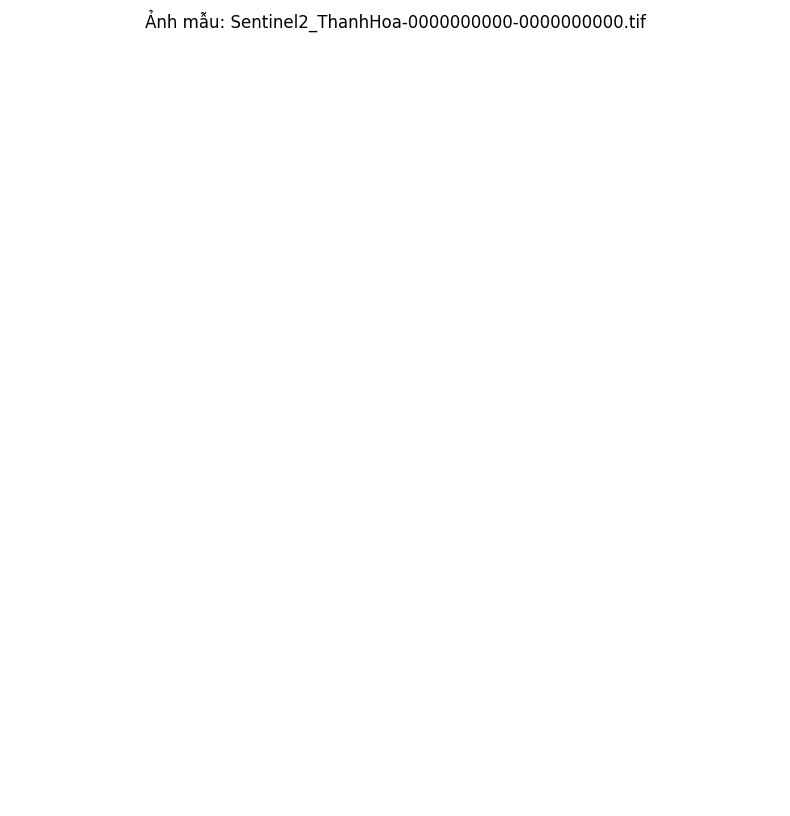

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Kiểm tra thông tin của một file ảnh mẫu
if len(sentinel_files) > 0:
    with rasterio.open(sentinel_files[0]) as src:
        print("\nThông tin file ảnh mẫu:")
        print(f"Tên file: {os.path.basename(sentinel_files[0])}")
        print(f"Kích thước: {src.width} x {src.height} pixels")
        print(f"Số kênh: {src.count}")
        print(f"Hệ tọa độ: {src.crs}")
        print(f"Geotransform: {src.transform}")
        print(f"Kiểu dữ liệu: {src.dtypes[0]}")

        # Hiển thị ảnh mẫu (3 kênh đầu tiên)
        if src.count >= 3:
            # Đọc 3 kênh đầu tiên
            rgb = src.read([1, 2, 3])
            # Chuyển từ (bands, height, width) sang (height, width, bands)
            rgb = np.transpose(rgb, (1, 2, 0))

            # Chuẩn hóa để hiển thị
            rgb_norm = rgb.astype(np.float32)
            for i in range(3):
                min_val = np.percentile(rgb_norm[:,:,i], 2)
                max_val = np.percentile(rgb_norm[:,:,i], 98)
                rgb_norm[:,:,i] = np.clip((rgb_norm[:,:,i] - min_val) / (max_val - min_val), 0, 1)

            plt.figure(figsize=(10, 10))
            plt.imshow(rgb_norm)
            plt.title(f"Ảnh mẫu: {os.path.basename(sentinel_files[0])}")
            plt.axis('off')
            plt.show()


In [ ]:
import joblib
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load model voting classifier
try:
    model = joblib.load(model_path)
    print("Đã load model thành công!")

    # Hiển thị thông tin model
    if isinstance(model, VotingClassifier):
        print("Model là VotingClassifier với các estimator:")
        for name, estimator in model.estimators:
            print(f" - {name}: {type(estimator).__name__}")
    else:
        print(f"Loại model: {type(model).__name__}")

except Exception as e:
    print(f"Lỗi khi load model: {e}")
    print("Vui lòng kiểm tra lại định dạng model và đường dẫn.")

# Định nghĩa các lớp phủ theo thứ tự đã cung cấp
class_names = [
    "forest", "open water", "residential land", "shrub", "rice paddy",
    "cropland", "barren land", "wetland", "aquaculture", "grassland"
]
n_classes = len(class_names)
print(f"Số lớp phủ: {n_classes}")
print(f"Các lớp phủ: {class_names}")

# Định nghĩa màu sắc cho từng lớp phủ
class_colors = [
    [0, 100, 0],     # forest - xanh đậm
    [0, 0, 255],     # open water - xanh dương
    [255, 0, 0],     # residential land - đỏ
    [0, 255, 0],     # shrub - xanh lá
    [255, 255, 0],   # rice paddy - vàng
    [255, 165, 0],   # cropland - cam
    [128, 128, 128], # barren land - xám
    [0, 255, 255],   # wetland - xanh ngọc
    [70, 130, 180],  # aquaculture - xanh biển
    [144, 238, 144]  # grassland - xanh nhạt
]

# Tạo colormap cho việc hiển thị kết quả
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(np.array(class_colors) / 255.0)


Đã load model thành công!
Model là VotingClassifier với các estimator:
 - lgbm: LGBMClassifier
 - catboost: CatBoostClassifier
 - xgb: XGBClassifier
Số lớp phủ: 10
Các lớp phủ: ['forest', 'open water', 'residential land', 'shrub', 'rice paddy', 'cropland', 'barren land', 'wetland', 'aquaculture', 'grassland']


In [ ]:
def predict_landcover(image_path, model, patch_size=1000):
    """
    Đọc ảnh và dự đoán lớp phủ sử dụng model scikit-learn

    Parameters:
    -----------
    image_path : str
        Đường dẫn đến file ảnh
    model : model object
        Model scikit-learn đã train
    patch_size : int
        Kích thước patch để xử lý (nếu cần)

    Returns:
    --------
    prediction : numpy array
        Mảng chứa kết quả dự đoán lớp phủ
    meta : dict
        Metadata của ảnh
    """
    print(f"Đang xử lý: {os.path.basename(image_path)}")

    # Đọc ảnh với rasterio
    with rasterio.open(image_path) as src:
        # Đọc tất cả các kênh
        image = src.read()
        meta = src.meta.copy()

    # Chuyển đổi định dạng ảnh từ (bands, height, width) sang (height, width, bands)
    image = np.transpose(image, (1, 2, 0))
    height, width, bands = image.shape
    print(f"  Kích thước ảnh: {width} x {height} x {bands}")

    # Khởi tạo mảng kết quả
    prediction = np.zeros((height, width), dtype=np.uint8)

    # Xử lý từng patch nếu ảnh quá lớn
    if height > patch_size or width > patch_size:
        print(f"  Ảnh quá lớn, xử lý theo từng patch {patch_size}x{patch_size}...")

        # Tính số patch theo chiều cao và chiều rộng
        n_h = int(np.ceil(height / patch_size))
        n_w = int(np.ceil(width / patch_size))
        total_patches = n_h * n_w

        print(f"  Tổng số patch: {total_patches} ({n_h}x{n_w})")

        from tqdm import tqdm

        for i in tqdm(range(n_h), desc="Xử lý patches"):
            for j in range(n_w):
                # Tính vị trí của patch
                h_start = i * patch_size
                w_start = j * patch_size
                h_end = min((i + 1) * patch_size, height)
                w_end = min((j + 1) * patch_size, width)

                # Cắt patch
                patch = image[h_start:h_end, w_start:w_end, :]
                patch_height, patch_width = patch.shape[:2]

                # Reshape patch thành ma trận 2D (n_pixels, n_bands) để dự đoán
                patch_flat = patch.reshape(patch_height * patch_width, bands)

                # Tạo mask cho các pixel có giá trị (không phải nodata)
                # Giả sử nodata là 0 hoặc giá trị âm trên tất cả các kênh
                valid_mask = np.all(patch_flat > 0, axis=1)

                if np.any(valid_mask):
                    # Chỉ dự đoán cho các pixel có giá trị
                    valid_features = patch_flat[valid_mask]

                    # Dự đoán
                    valid_predictions = model.predict(valid_features)

                    # Tạo mảng kết quả cho patch
                    patch_result = np.zeros((patch_height * patch_width), dtype=np.uint8)

                    # Gán kết quả dự đoán vào các vị trí pixel có giá trị
                    patch_result[valid_mask] = valid_predictions

                    # Reshape lại thành kích thước patch
                    patch_result = patch_result.reshape(patch_height, patch_width)

                    # Ghi kết quả vào mảng prediction
                    prediction[h_start:h_end, w_start:w_end] = patch_result
    else:
        # Nếu ảnh đủ nhỏ, dự đoán trực tiếp
        print("  Dự đoán trực tiếp...")

        # Reshape ảnh thành ma trận 2D (n_pixels, n_bands)
        image_flat = image.reshape(height * width, bands)

        # Tạo mask cho các pixel có giá trị
        valid_mask = np.all(image_flat > 0, axis=1)

        if np.any(valid_mask):
            # Chỉ dự đoán cho các pixel có giá trị
            valid_features = image_flat[valid_mask]

            # Dự đoán
            valid_predictions = model.predict(valid_features)

            # Tạo mảng kết quả
            image_result = np.zeros(height * width, dtype=np.uint8)

            # Gán kết quả dự đoán vào các vị trí pixel có giá trị
            image_result[valid_mask] = valid_predictions

            # Reshape lại thành kích thước ảnh
            prediction = image_result.reshape(height, width)

    print(f"  Hoàn thành dự đoán cho {os.path.basename(image_path)}")
    return prediction, meta



Xử lý file 1/16: Sentinel2_ThanhHoa-0000000000-0000000000.tif
Đang xử lý: Sentinel2_ThanhHoa-0000000000-0000000000.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000000000-0000000000.tif


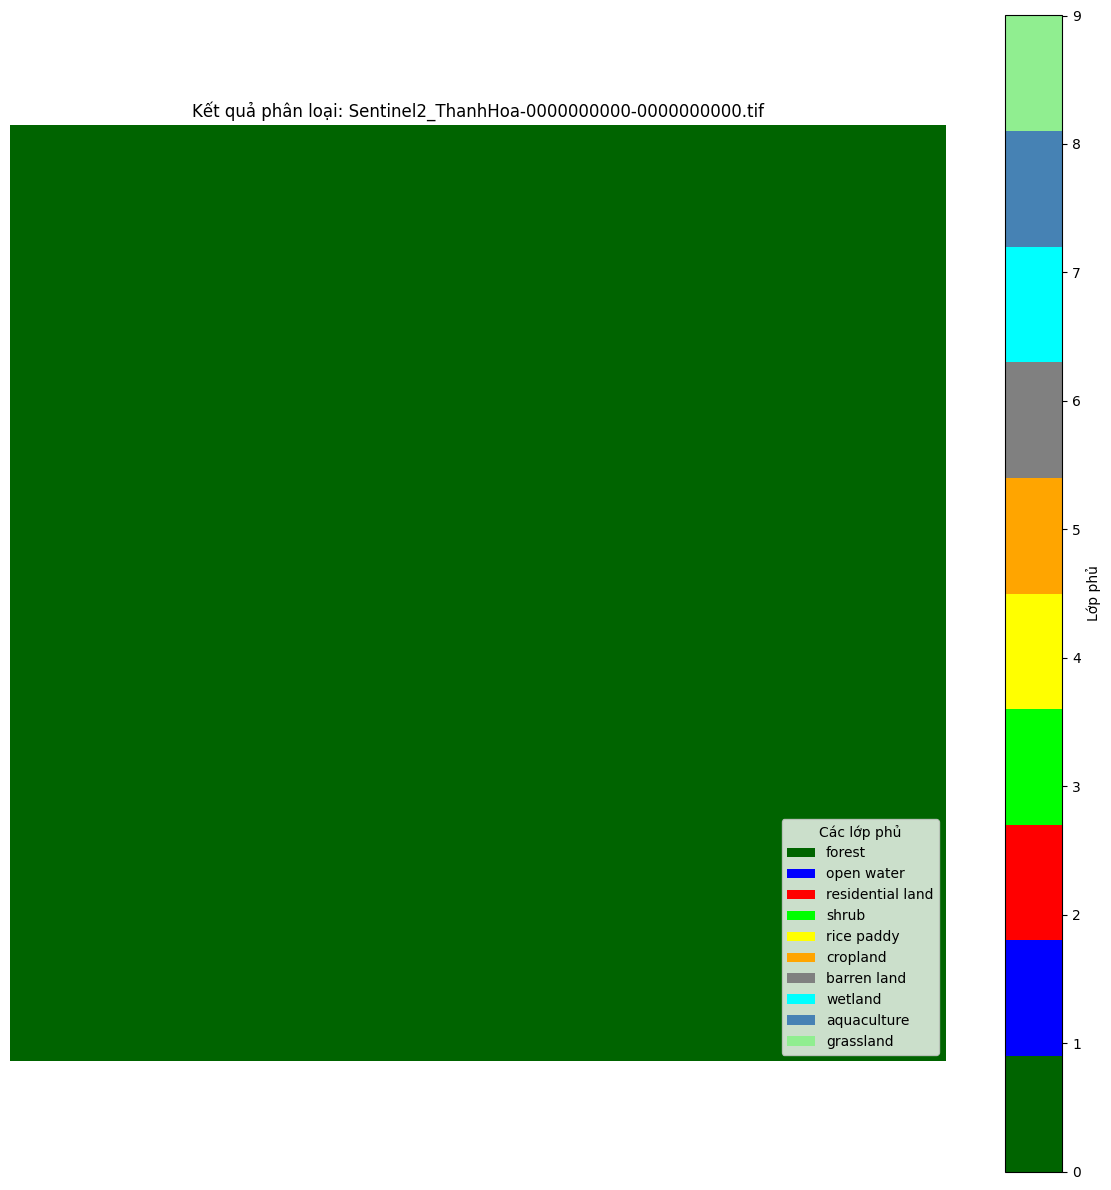

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000000000-0000000000.tif

Xử lý file 2/16: Sentinel2_ThanhHoa-0000000000-0000004608.tif
Đang xử lý: Sentinel2_ThanhHoa-0000000000-0000004608.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000000000-0000004608.tif


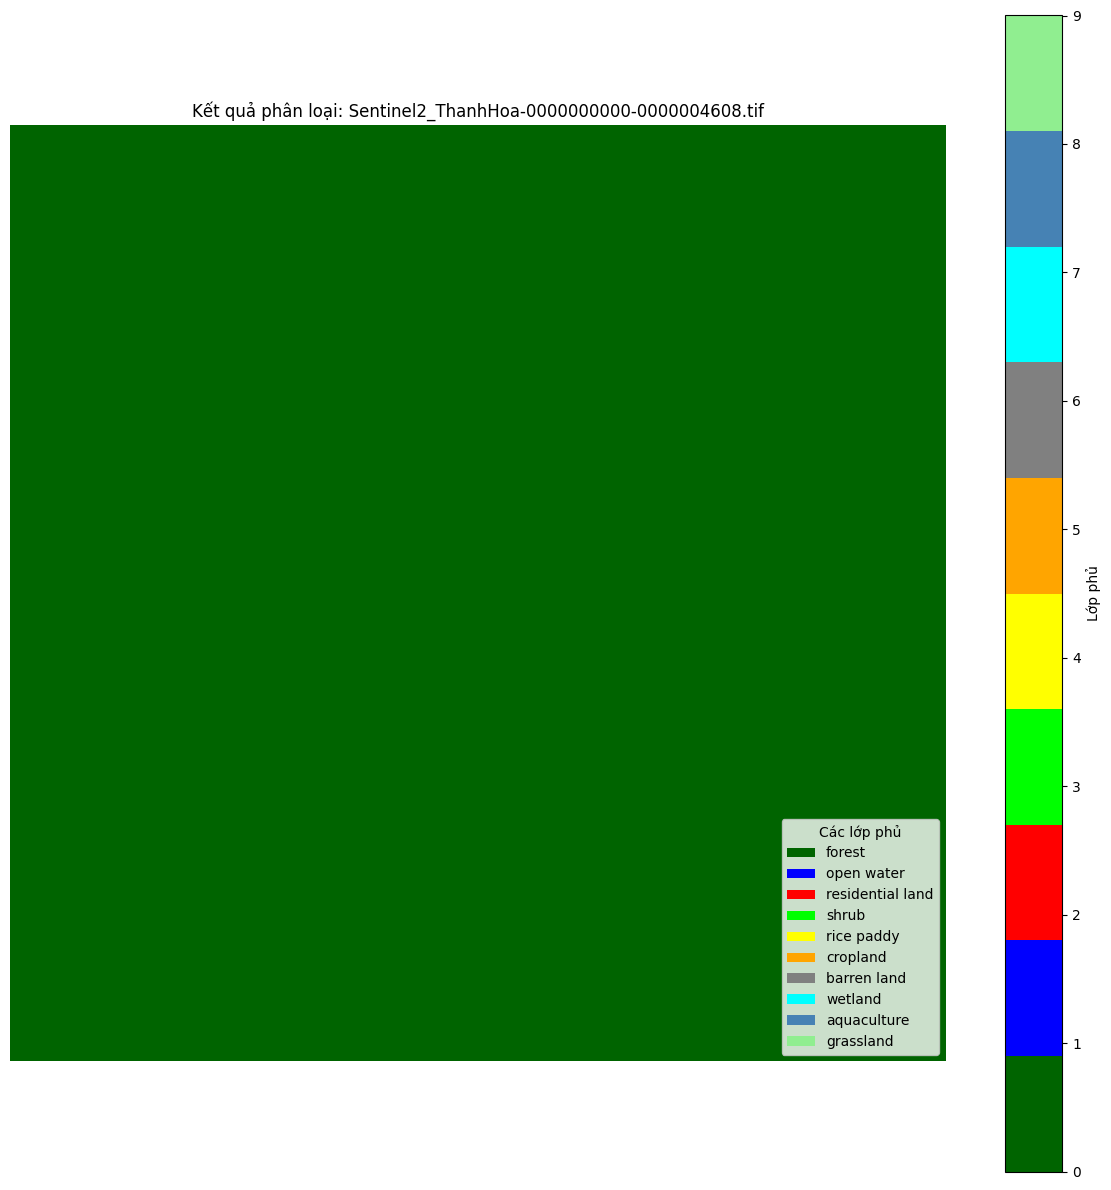

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000000000-0000004608.tif

Xử lý file 3/16: Sentinel2_ThanhHoa-0000000000-0000009216.tif
Đang xử lý: Sentinel2_ThanhHoa-0000000000-0000009216.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000000000-0000009216.tif


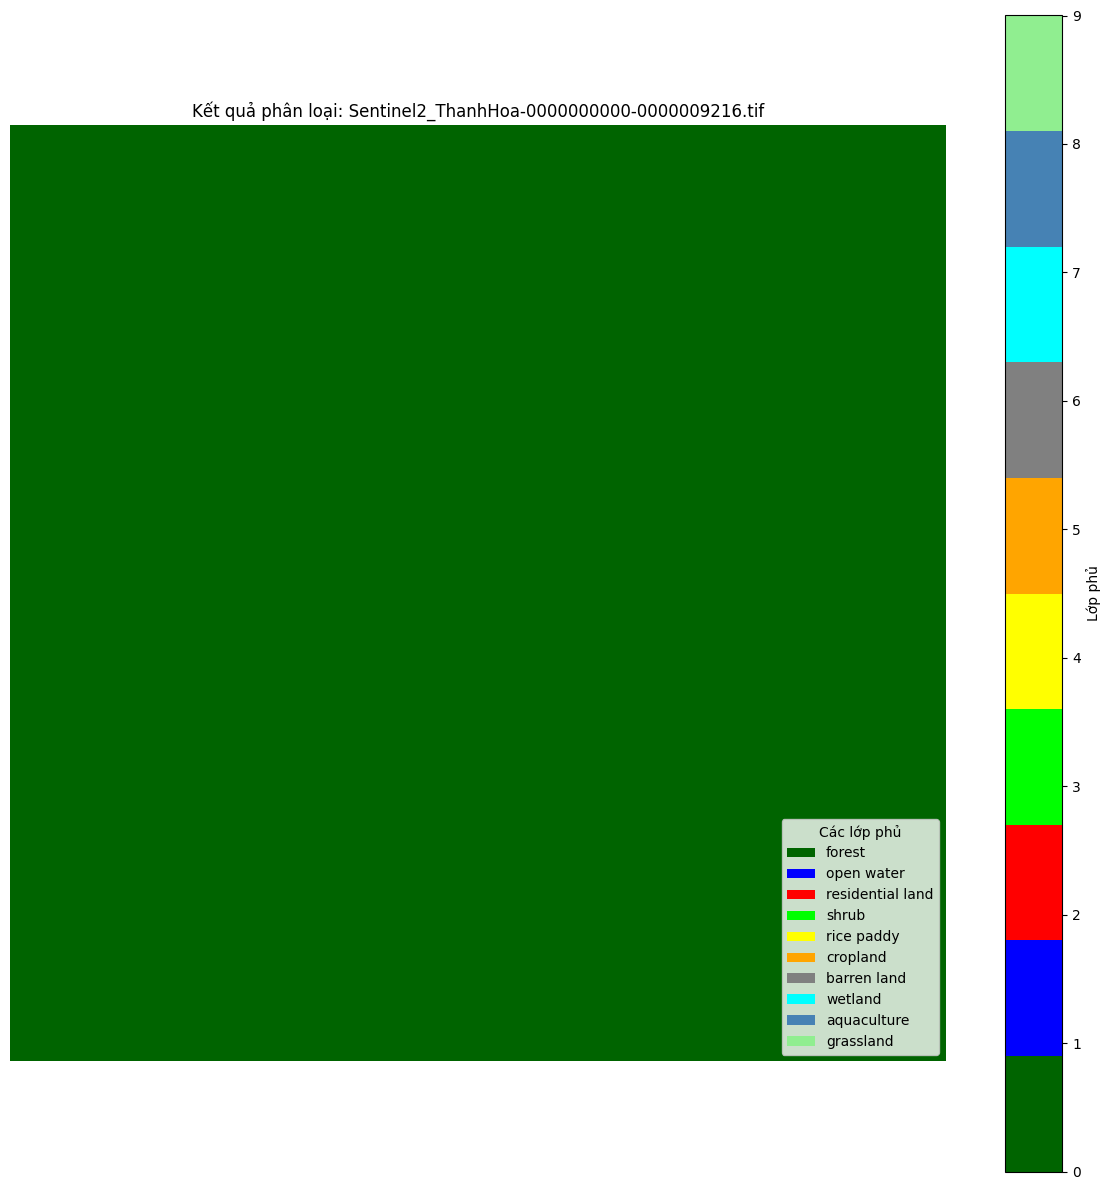

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000000000-0000009216.tif

Xử lý file 4/16: Sentinel2_ThanhHoa-0000000000-0000013824.tif
Đang xử lý: Sentinel2_ThanhHoa-0000000000-0000013824.tif
  Kích thước ảnh: 4376 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000000000-0000013824.tif


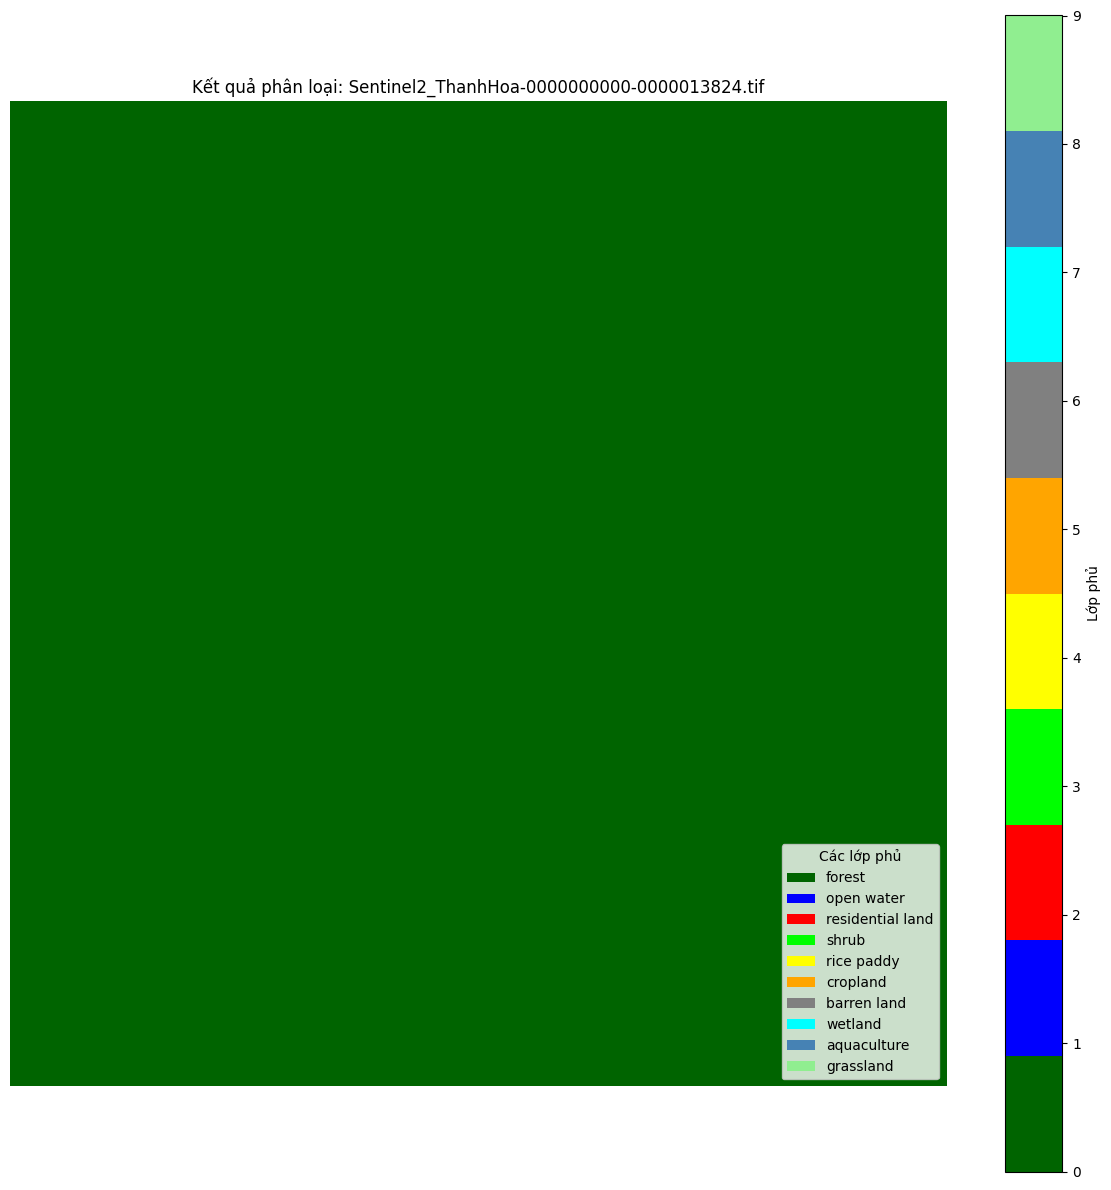

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000000000-0000013824.tif

Xử lý file 5/16: Sentinel2_ThanhHoa-0000004608-0000000000.tif
Đang xử lý: Sentinel2_ThanhHoa-0000004608-0000000000.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000004608-0000000000.tif


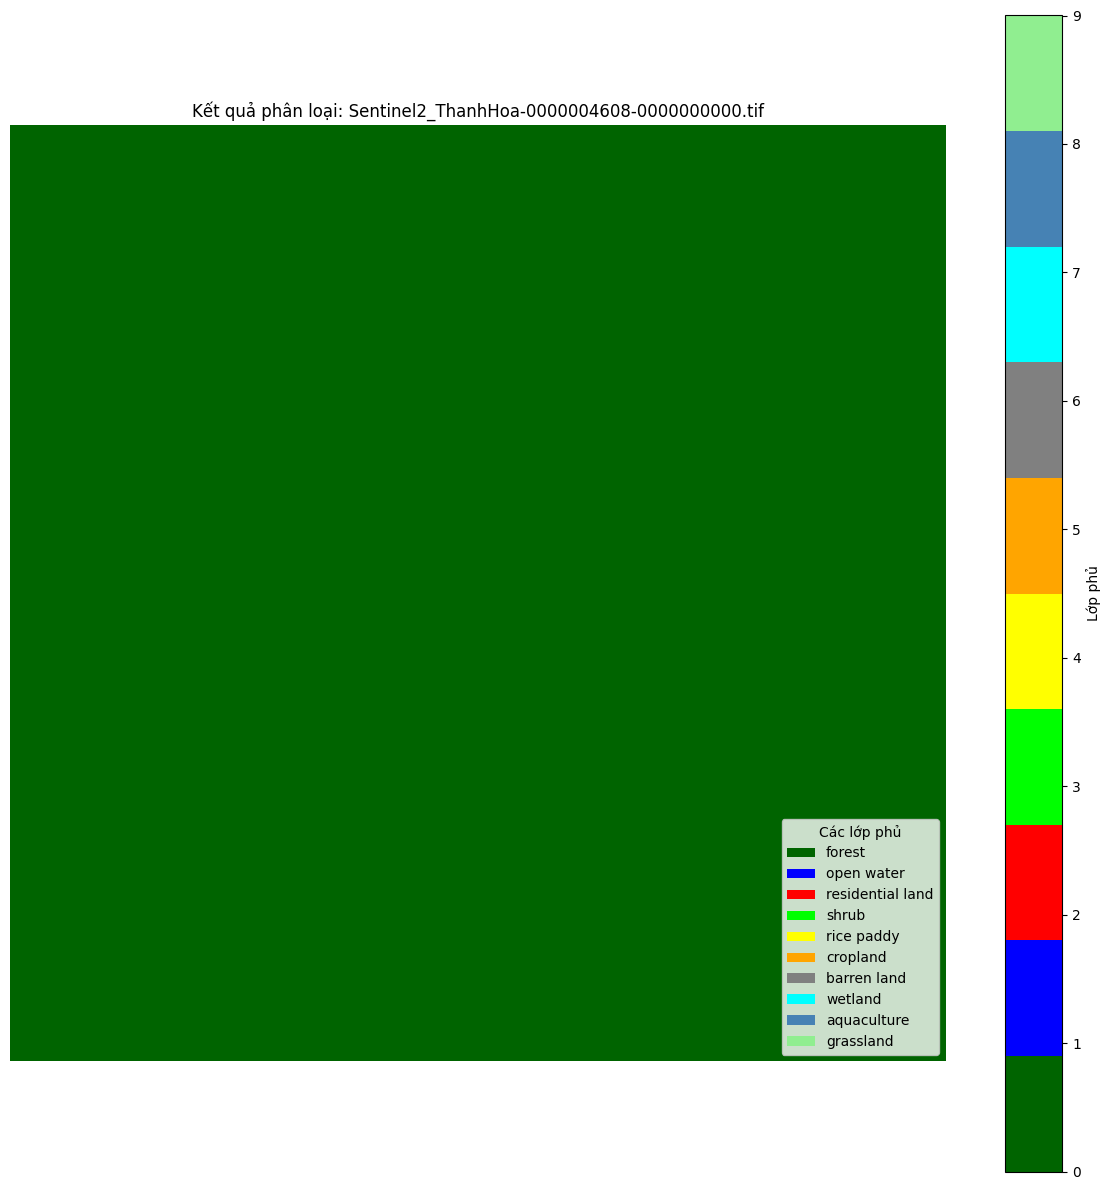

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000004608-0000000000.tif

Xử lý file 6/16: Sentinel2_ThanhHoa-0000004608-0000004608.tif
Đang xử lý: Sentinel2_ThanhHoa-0000004608-0000004608.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000004608-0000004608.tif


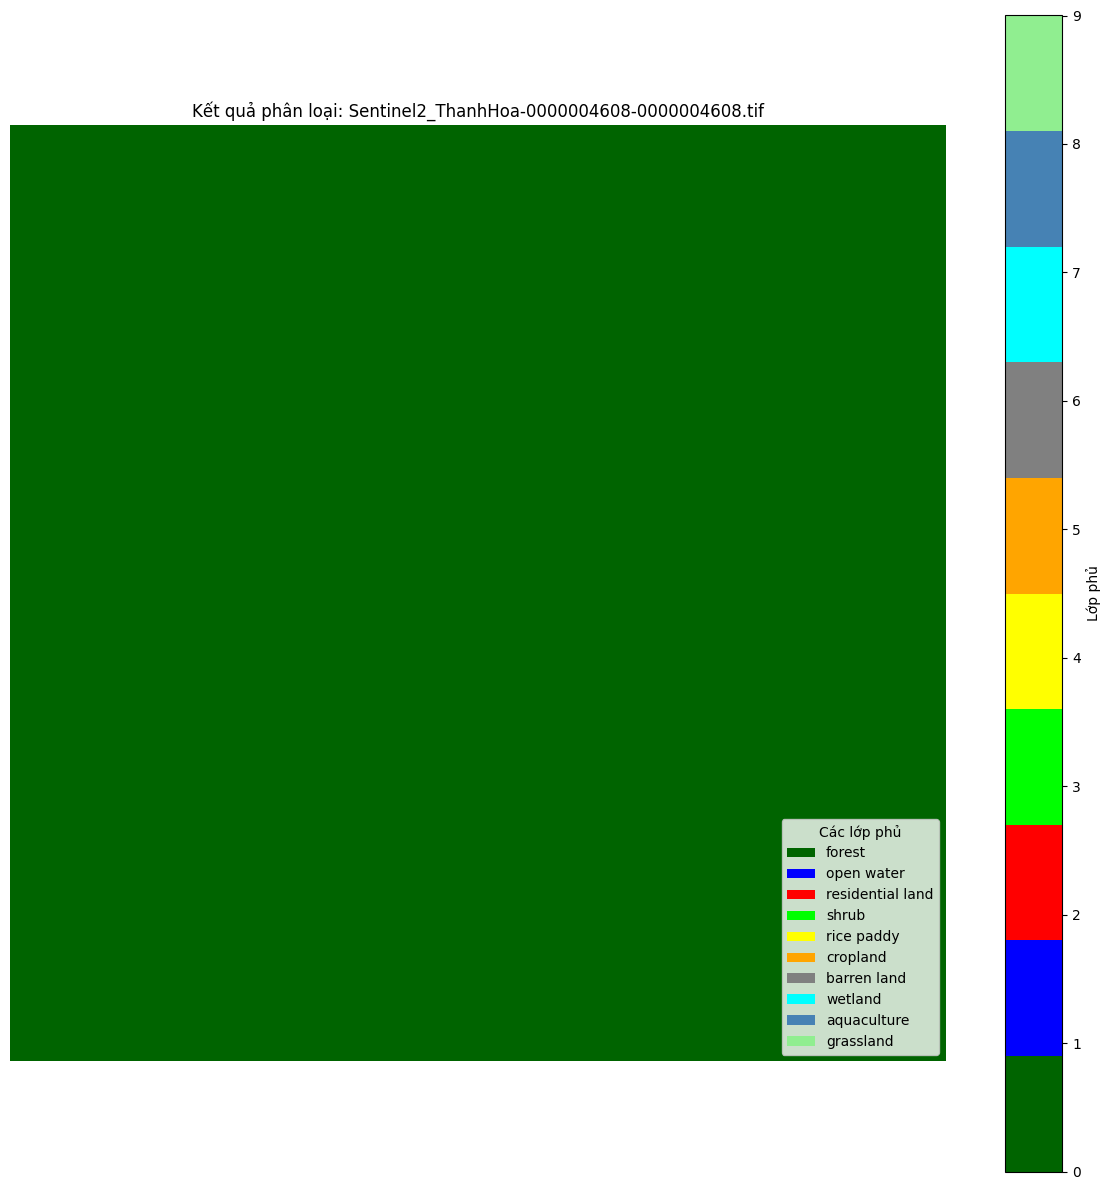

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000004608-0000004608.tif

Xử lý file 7/16: Sentinel2_ThanhHoa-0000004608-0000009216.tif
Đang xử lý: Sentinel2_ThanhHoa-0000004608-0000009216.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000004608-0000009216.tif


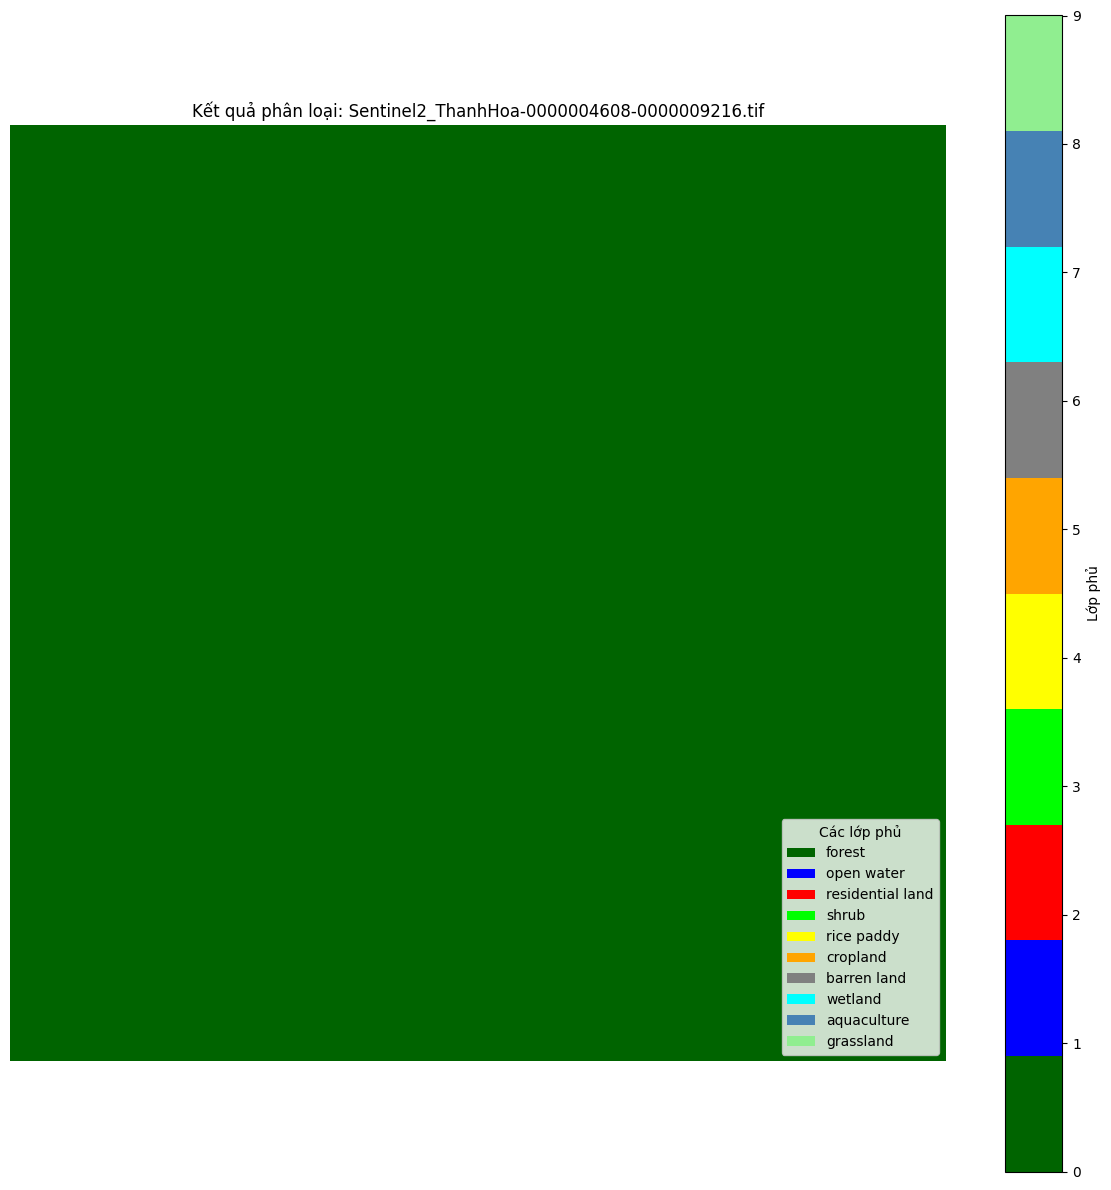

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000004608-0000009216.tif

Xử lý file 8/16: Sentinel2_ThanhHoa-0000004608-0000013824.tif
Đang xử lý: Sentinel2_ThanhHoa-0000004608-0000013824.tif
  Kích thước ảnh: 4376 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000004608-0000013824.tif


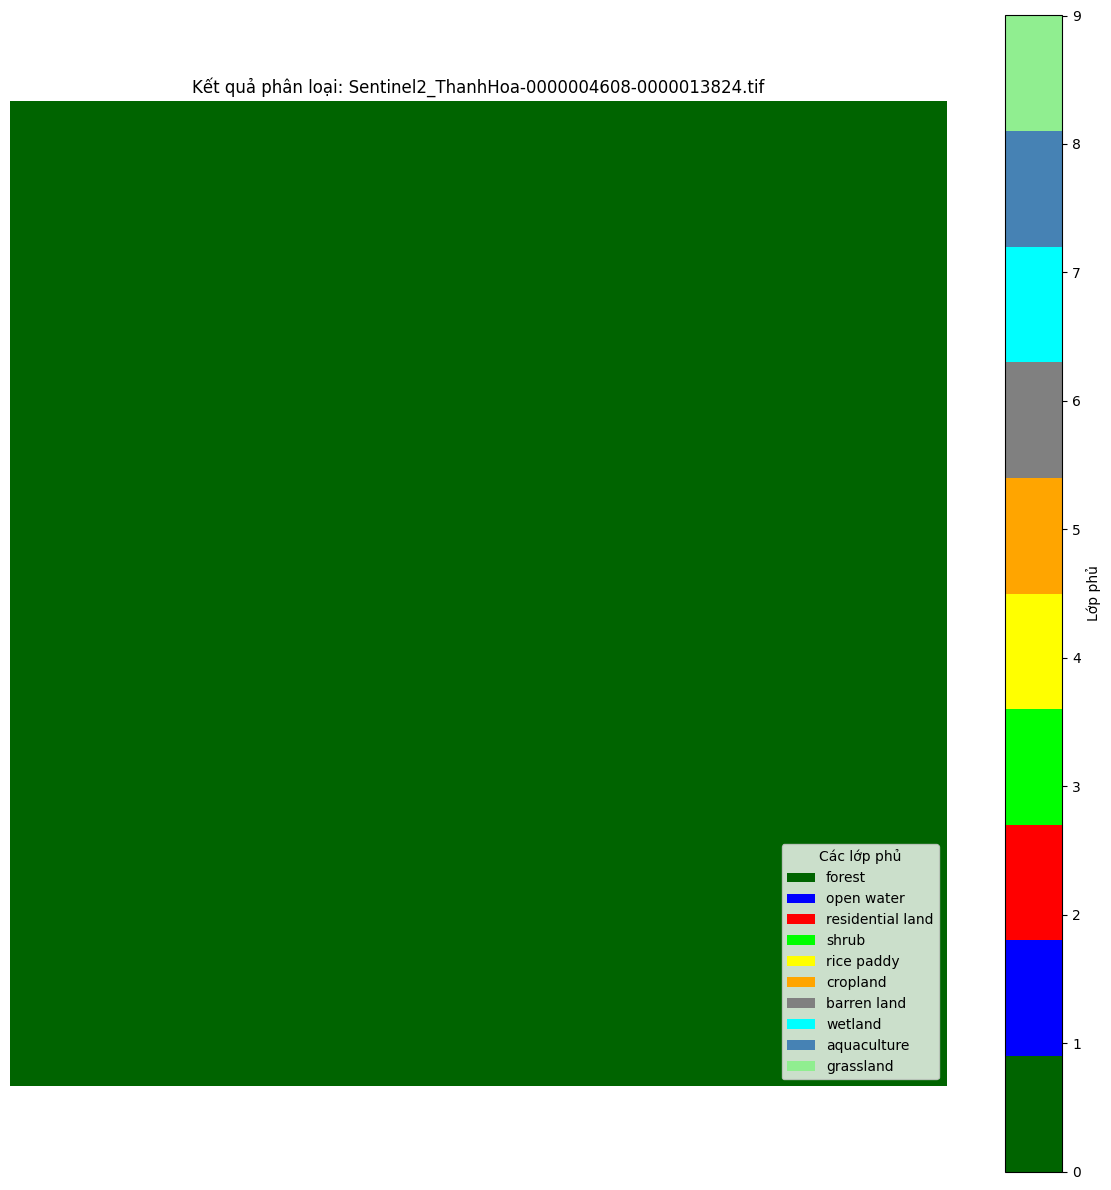

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000004608-0000013824.tif

Xử lý file 9/16: Sentinel2_ThanhHoa-0000009216-0000000000.tif
Đang xử lý: Sentinel2_ThanhHoa-0000009216-0000000000.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000009216-0000000000.tif


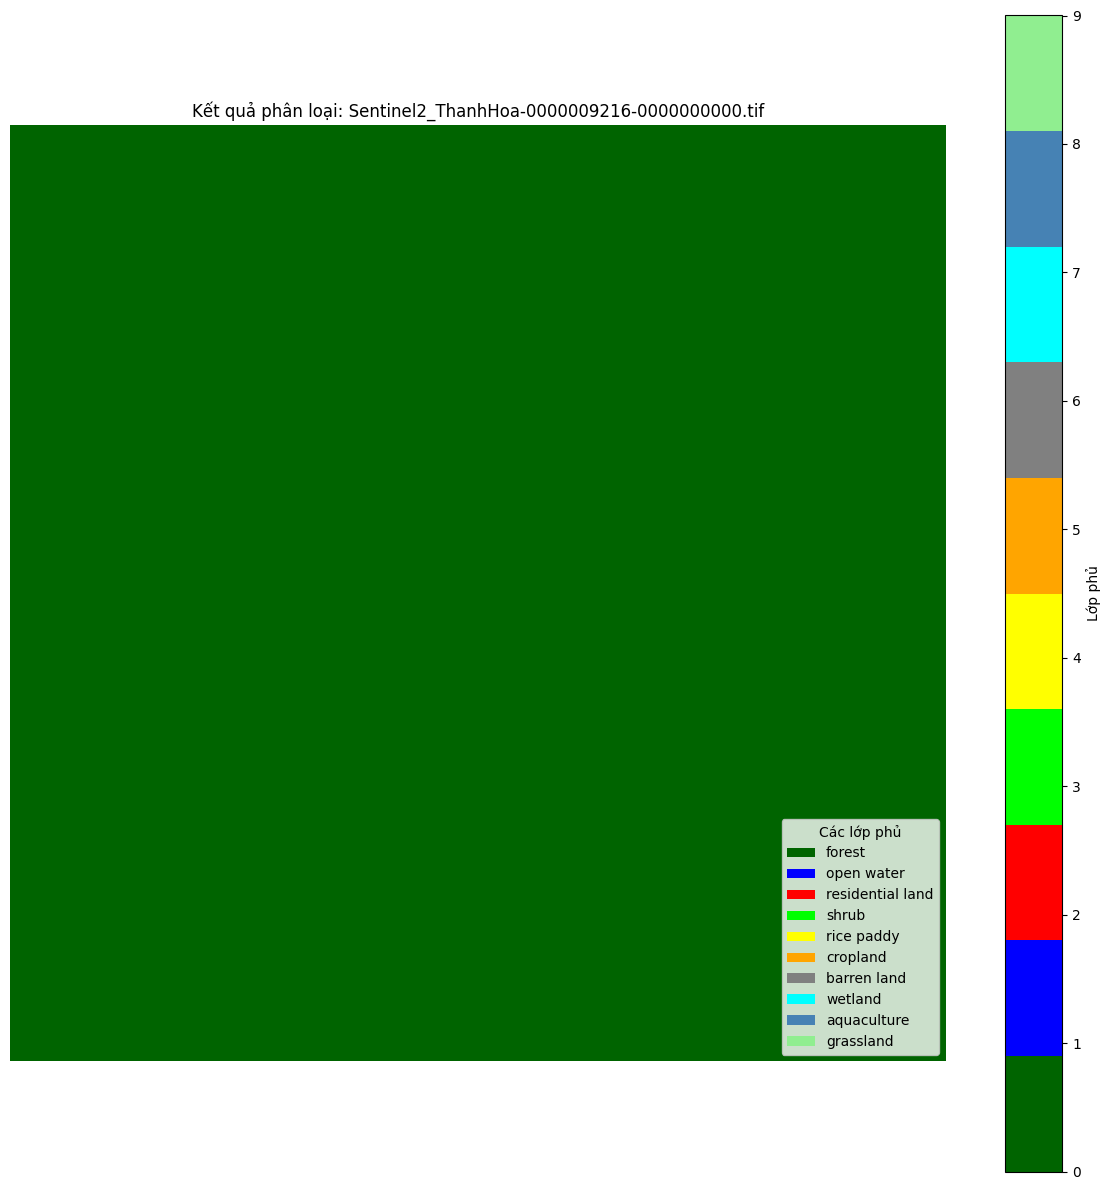

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000009216-0000000000.tif

Xử lý file 10/16: Sentinel2_ThanhHoa-0000009216-0000004608.tif
Đang xử lý: Sentinel2_ThanhHoa-0000009216-0000004608.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000009216-0000004608.tif


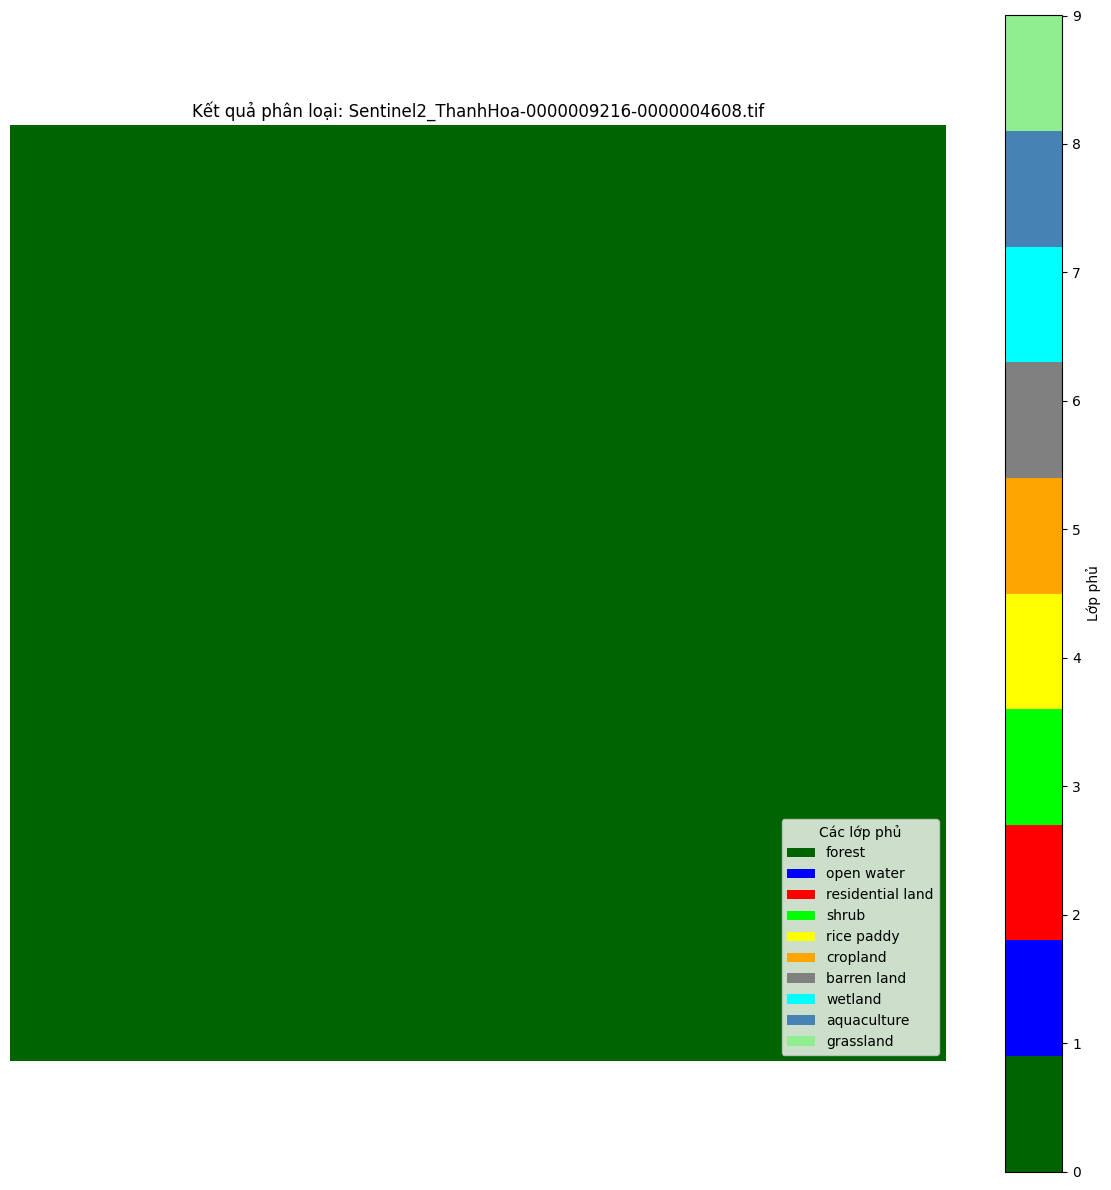

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000009216-0000004608.tif

Xử lý file 11/16: Sentinel2_ThanhHoa-0000009216-0000009216.tif
Đang xử lý: Sentinel2_ThanhHoa-0000009216-0000009216.tif
  Kích thước ảnh: 4608 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000009216-0000009216.tif


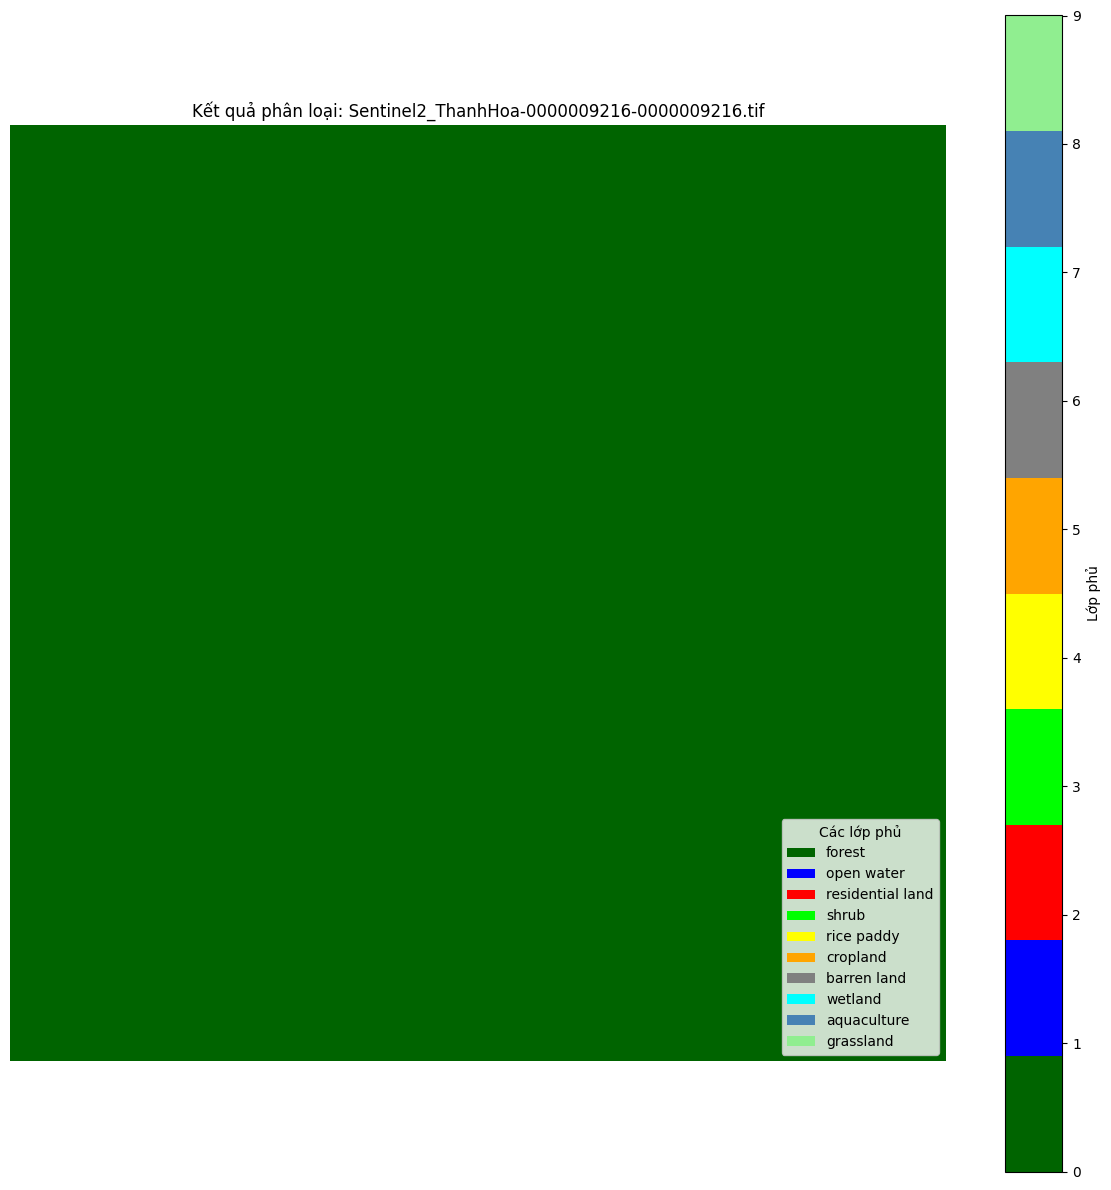

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000009216-0000009216.tif

Xử lý file 12/16: Sentinel2_ThanhHoa-0000009216-0000013824.tif
Đang xử lý: Sentinel2_ThanhHoa-0000009216-0000013824.tif
  Kích thước ảnh: 4376 x 4608 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 25 (5x5)


Xử lý patches: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000009216-0000013824.tif


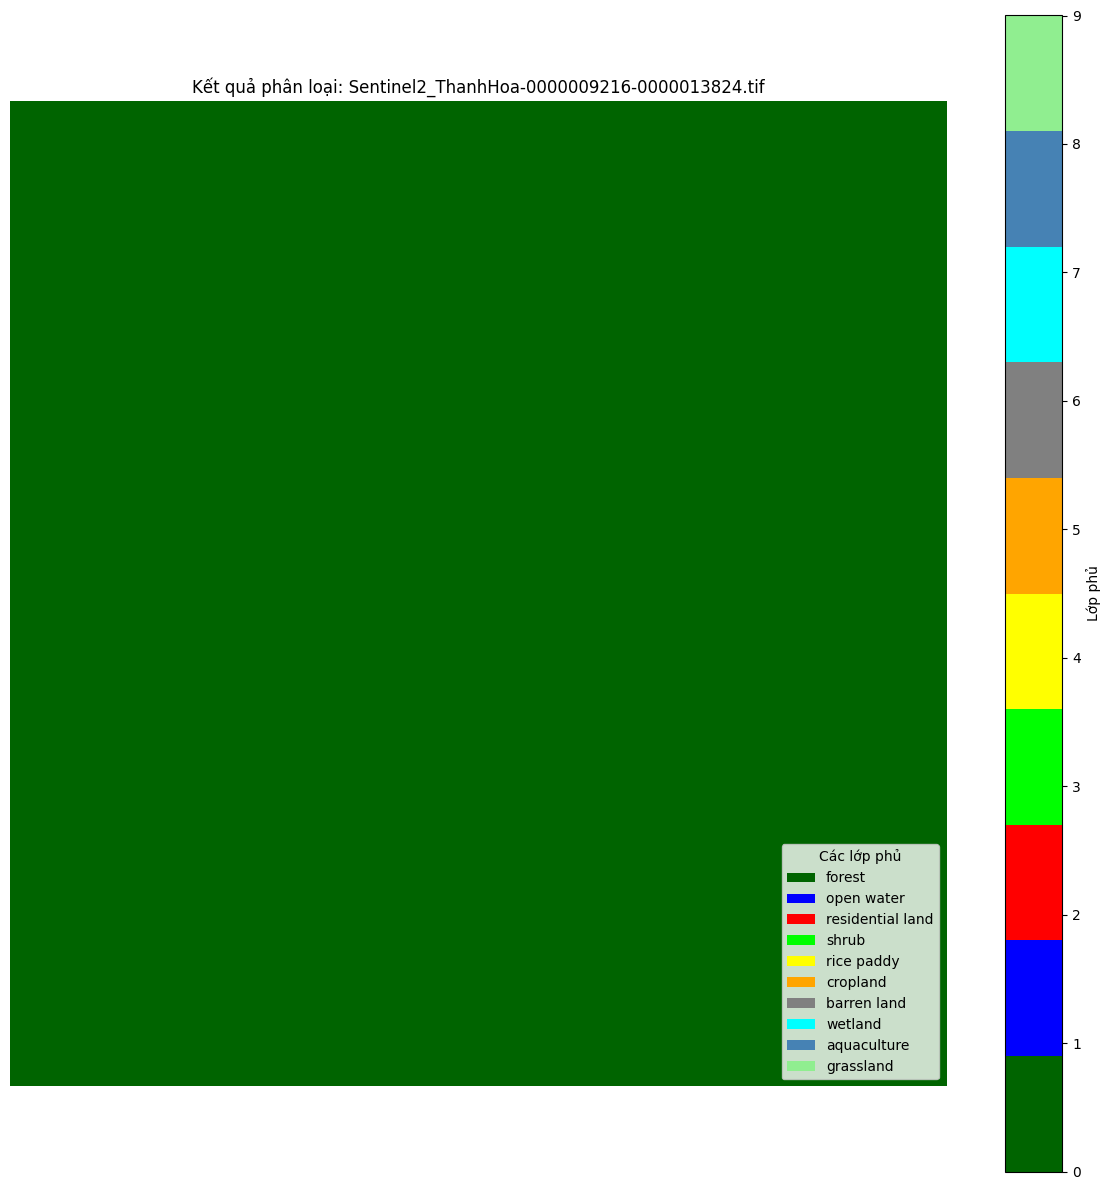

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000009216-0000013824.tif

Xử lý file 13/16: Sentinel2_ThanhHoa-0000013824-0000000000.tif
Đang xử lý: Sentinel2_ThanhHoa-0000013824-0000000000.tif
  Kích thước ảnh: 4608 x 1577 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 10 (2x5)


Xử lý patches: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000013824-0000000000.tif


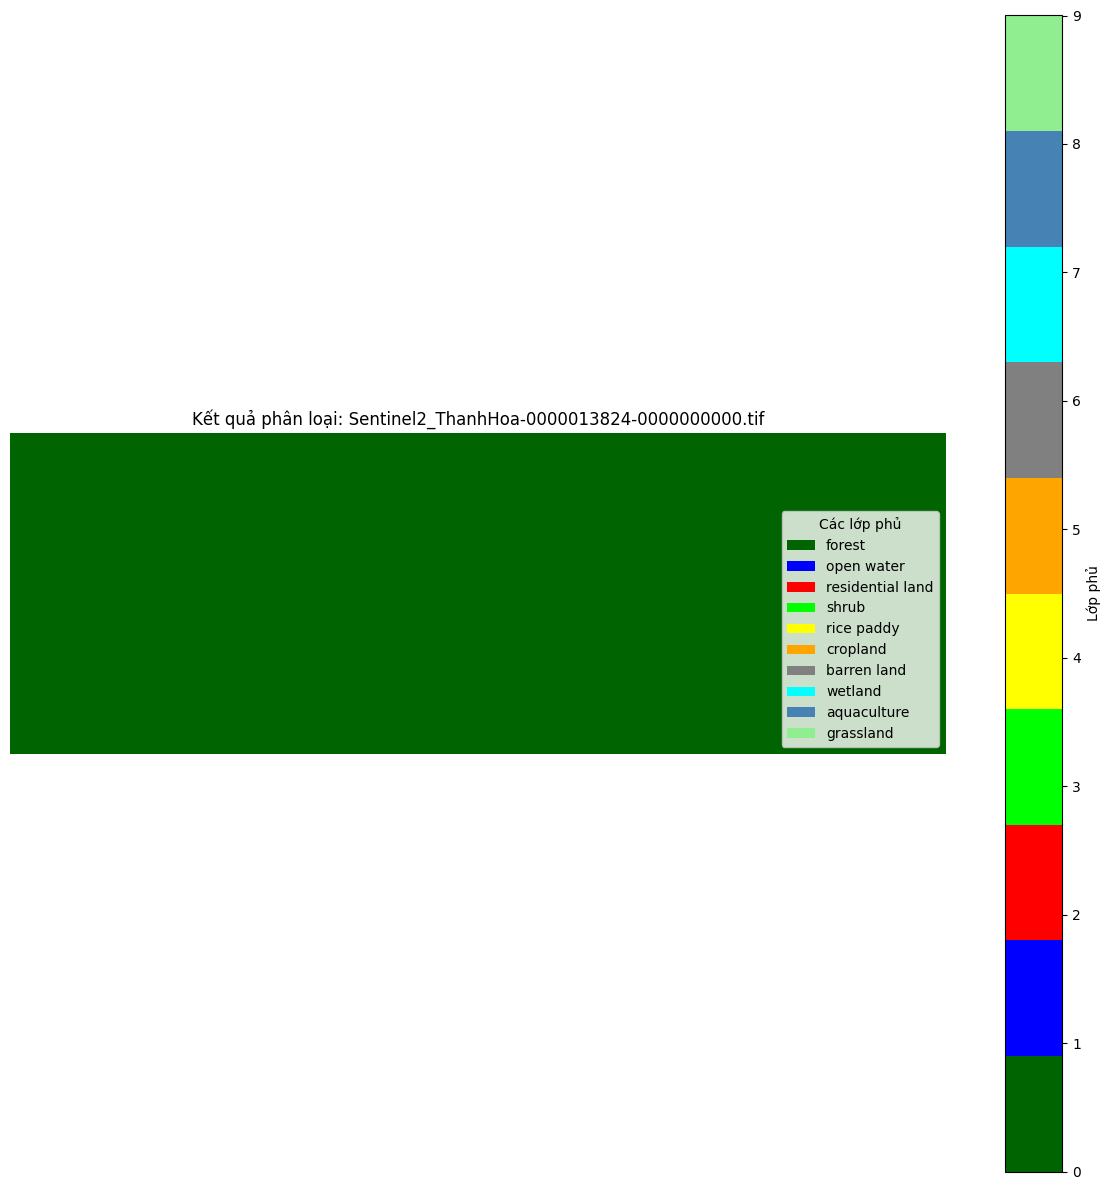

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000013824-0000000000.tif

Xử lý file 14/16: Sentinel2_ThanhHoa-0000013824-0000004608.tif
Đang xử lý: Sentinel2_ThanhHoa-0000013824-0000004608.tif
  Kích thước ảnh: 4608 x 1577 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 10 (2x5)


Xử lý patches: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000013824-0000004608.tif


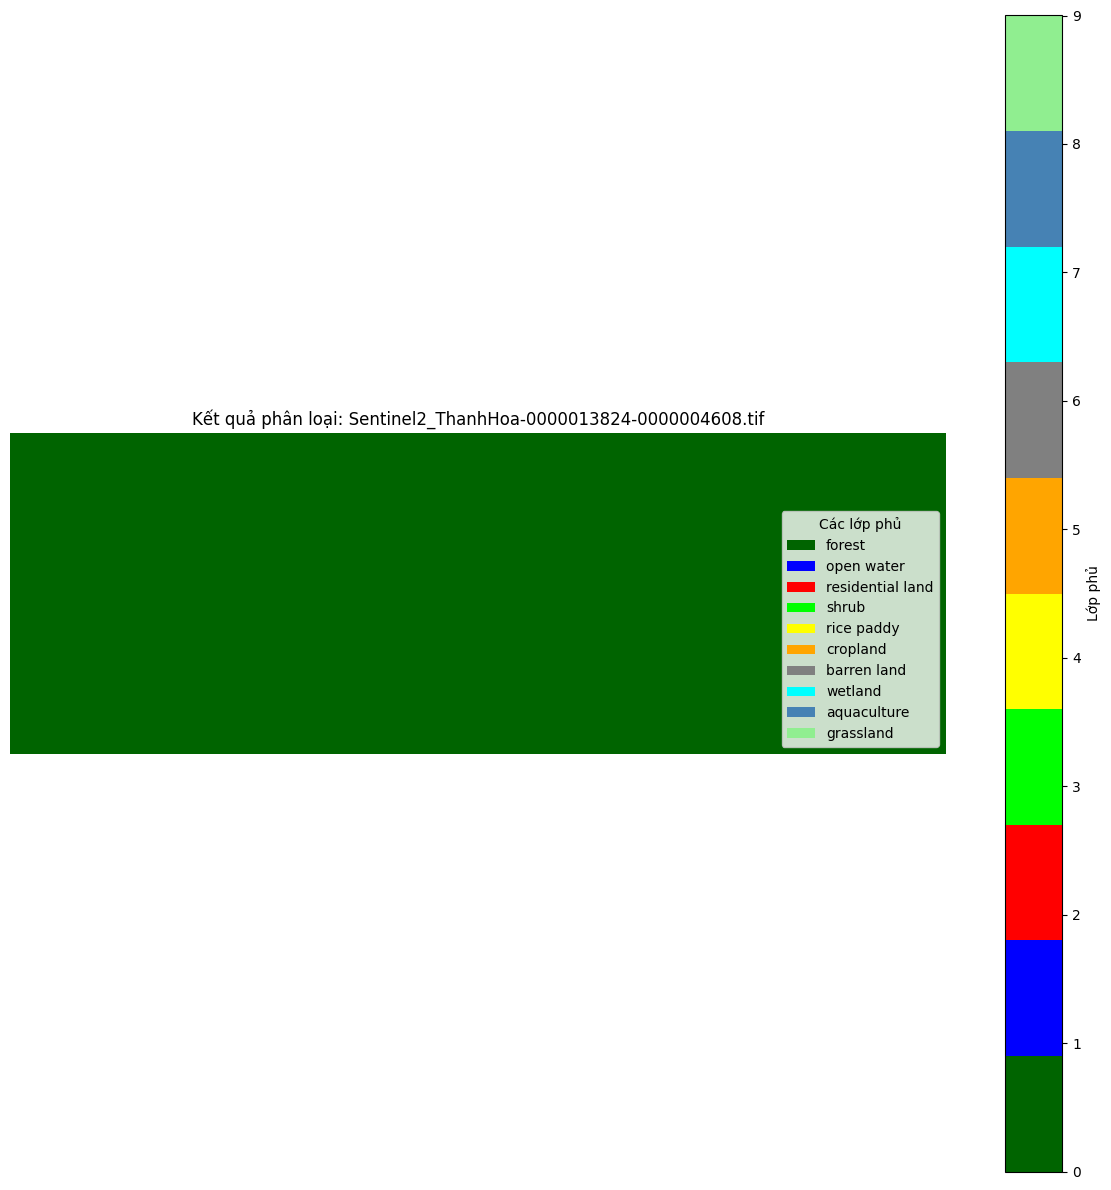

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000013824-0000004608.tif

Xử lý file 15/16: Sentinel2_ThanhHoa-0000013824-0000009216.tif
Đang xử lý: Sentinel2_ThanhHoa-0000013824-0000009216.tif
  Kích thước ảnh: 4608 x 1577 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 10 (2x5)


Xử lý patches: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000013824-0000009216.tif


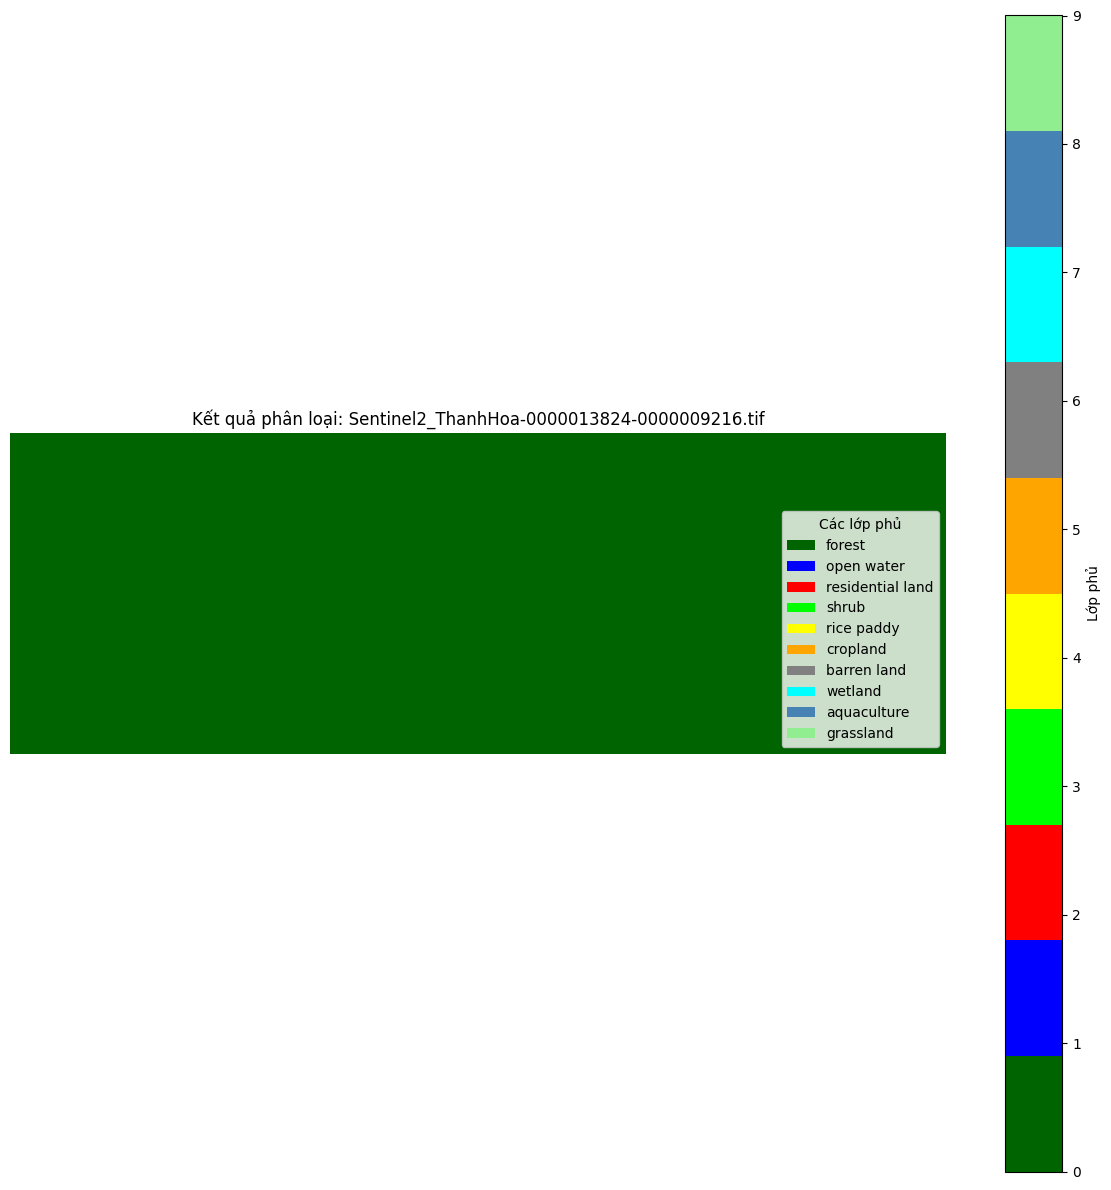

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000013824-0000009216.tif

Xử lý file 16/16: Sentinel2_ThanhHoa-0000013824-0000013824.tif
Đang xử lý: Sentinel2_ThanhHoa-0000013824-0000013824.tif
  Kích thước ảnh: 4376 x 1577 x 26
  Ảnh quá lớn, xử lý theo từng patch 1000x1000...
  Tổng số patch: 10 (2x5)


Xử lý patches: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


  Hoàn thành dự đoán cho Sentinel2_ThanhHoa-0000013824-0000013824.tif


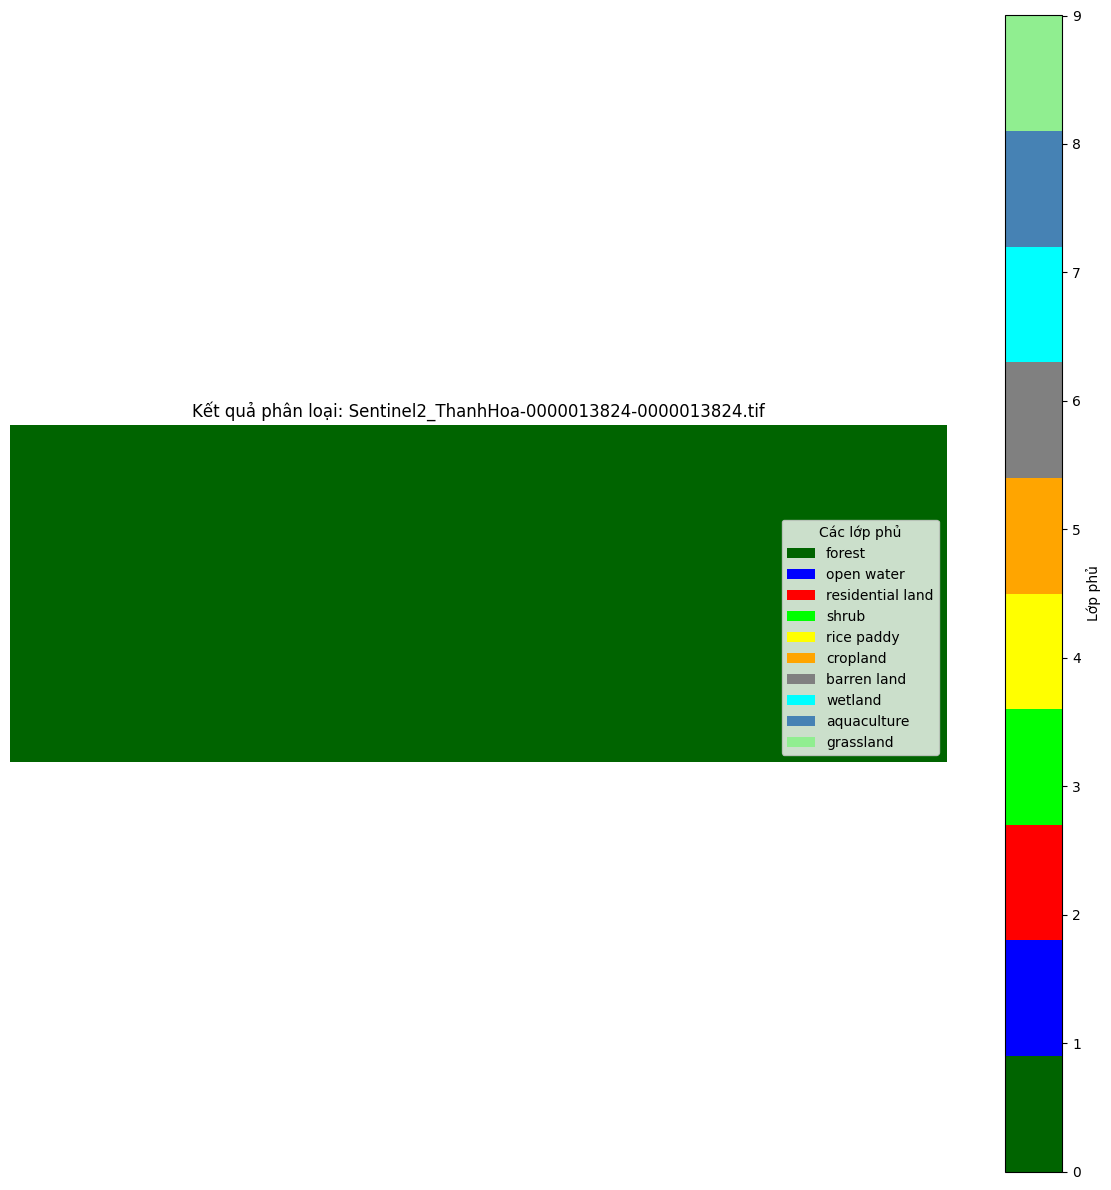

  Đã lưu kết quả tạm thời tại: /content/temp_results/temp_Sentinel2_ThanhHoa-0000013824-0000013824.tif


In [ ]:
import os
from tqdm import tqdm
import rasterio
from rasterio.merge import merge

# Tạo thư mục để lưu kết quả tạm thời
temp_dir = '/content/temp_results'
os.makedirs(temp_dir, exist_ok=True)

# Tạo thư mục để lưu kết quả cuối cùng
output_dir = '/content/drive/MyDrive/ThanhHoa/results'
os.makedirs(output_dir, exist_ok=True)

# Danh sách để lưu các file kết quả tạm thời
temp_files = []

# Xử lý từng file ảnh
for idx, file_path in enumerate(sentinel_files):
    try:
        print(f"\nXử lý file {idx+1}/{len(sentinel_files)}: {os.path.basename(file_path)}")

        # Dự đoán lớp phủ
        prediction, meta = predict_landcover(file_path, model)

        # Tạo tên file tạm thời
        temp_file = os.path.join(temp_dir, f"temp_{os.path.basename(file_path)}")

        # Cập nhật metadata
        meta.update({
            'driver': 'GTiff',
            'dtype': 'uint8',
            'count': 1,
            'nodata': 0
        })

        # Lưu kết quả dự đoán ra file tạm
        with rasterio.open(temp_file, 'w', **meta) as dst:
            dst.write(prediction.astype(np.uint8), 1)

        # Thêm vào danh sách để ghép sau
        temp_files.append(temp_file)

        # Hiển thị kết quả dự đoán
        plt.figure(figsize=(12, 12))
        plt.imshow(prediction, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(class_names)-1)
        plt.colorbar(ticks=range(len(class_names)), label='Lớp phủ')
        plt.title(f"Kết quả phân loại: {os.path.basename(file_path)}")

        # Thêm chú thích
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=np.array(class_colors[i])/255.0,
                                 label=class_names[i])
                           for i in range(len(class_names))]
        plt.legend(handles=legend_elements, loc='lower right', title="Các lớp phủ")

        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"  Đã lưu kết quả tạm thời tại: {temp_file}")

    except Exception as e:
        print(f"  Lỗi khi xử lý {os.path.basename(file_path)}: {e}")


In [ ]:
from tqdm import tqdm
import rasterio
from rasterio.merge import merge
output_dir = '/content/drive/MyDrive/ThanhHoa/results'

if 'temp_files' not in locals():
    temp_dir = '/content/temp_results'
    temp_files = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.startswith('temp_') and f.endswith('.tif')]

# Kiểm tra xem có file tạm nào không
if len(temp_files) > 0:
    print(f"\nĐang ghép {len(temp_files)} file kết quả...")
if len(temp_files) > 0:
    print(f"\nĐang ghép {len(temp_files)} file kết quả...")

    try:
        # Mở các file đã xử lý để ghép
        src_datasets = [rasterio.open(f) for f in temp_files]

        # Ghép các tile lại với nhau
        mosaic, out_transform = merge(src_datasets)

        # Lấy metadata từ file đầu tiên
        with rasterio.open(temp_files[0]) as src:
            out_meta = src.meta.copy()

        # Cập nhật metadata cho kết quả ghép
        out_meta.update({
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_transform,
            "count": 1,
            "dtype": "uint8",
            "nodata": 0
        })

        # Đường dẫn file kết quả
        output_file = os.path.join(output_dir, "ThanhHoa_landcover_map.tif")

        # Lưu kết quả ghép
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(mosaic)

        # Đóng các file tạm
        for src in src_datasets:
            src.close()

        print(f"Đã ghép và lưu bản đồ lớp phủ tại: {output_file}")

        # Hiển thị bản đồ lớp phủ cuối cùng
        with rasterio.open(output_file) as src:
            final_map = src.read(1)

            plt.figure(figsize=(15, 15))
            plt.imshow(final_map, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(class_names)-1)
            plt.colorbar(ticks=range(len(class_names)), label='Lớp phủ')
            plt.title("Bản đồ lớp phủ tỉnh Thanh Hóa")

            # Thêm chú thích
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=np.array(class_colors[i])/255.0,
                                     label=class_names[i])
                               for i in range(len(class_names))]
            plt.legend(handles=legend_elements, loc='lower right', title="Các lớp phủ")

            plt.axis('off')
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Lỗi khi ghép các file: {e}")
else:
    print("Không có file kết quả nào để ghép!")



Đang ghép 16 file kết quả...

Đang ghép 16 file kết quả...
Đã ghép và lưu bản đồ lớp phủ tại: /content/drive/MyDrive/ThanhHoa/results/ThanhHoa_landcover_map.tif


In [ ]:
!pip install numpy==1.23.5

import rasterio
import numpy as np
import os
import tempfile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.warp import transform_bounds

# Cài đặt và import arcgis
!pip install arcgis
from arcgis.gis import GIS
from arcgis.mapping import WebMap

# Định nghĩa các lớp phủ và màu sắc
class_names = [
    "forest", "open water", "residential land", "shrub", "rice paddy",
    "cropland", "barren land", "wetland", "aquaculture", "grassland"
]

# Định nghĩa màu sắc cho từng lớp phủ
class_colors = [
    [0, 100, 0],     # forest - xanh đậm
    [0, 0, 255],     # open water - xanh dương
    [255, 0, 0],     # residential land - đỏ
    [0, 255, 0],     # shrub - xanh lá
    [255, 255, 0],   # rice paddy - vàng
    [255, 165, 0],   # cropland - cam
    [128, 128, 128], # barren land - xám
    [0, 255, 255],   # wetland - xanh ngọc
    [70, 130, 180],  # aquaculture - xanh biển
    [144, 238, 144]  # grassland - xanh nhạt
]

# Tạo colormap cho việc hiển thị kết quả
cmap = mcolors.ListedColormap(np.array(class_colors) / 255.0)

# Đường dẫn đến file kết quả
output_dir = '/content/drive/MyDrive/ThanhHoa/results'
output_file = os.path.join(output_dir, "ThanhHoa_landcover_map.tif")

try:
    # Đọc raster
    with rasterio.open(output_file) as src:
        # Đọc dữ liệu
        data = src.read(1)

        # Lấy thông tin tọa độ
        bounds = src.bounds

        # Chuyển đổi tọa độ từ hệ tọa độ của ảnh sang WGS84 (lat, lon)
        if src.crs:
            west, south, east, north = transform_bounds(src.crs, "EPSG:4326",
                                                       bounds.left, bounds.bottom,
                                                       bounds.right, bounds.top)

            # Tính toán tọa độ trung tâm
            center_lon = (west + east) / 2
            center_lat = (south + north) / 2
        else:
            # Sử dụng tọa độ mặc định nếu không xác định được
            print("Không thể xác định hệ tọa độ, sử dụng vị trí mặc định")
            center_lat, center_lon = 19.8, 105.8  # Vị trí tỉnh Thanh Hóa
            west, south, east, north = center_lon - 0.5, center_lat - 0.5, center_lon + 0.5, center_lat + 0.5

        # Tạo một ảnh màu từ dữ liệu raster
        colored_data = np.zeros((data.shape[0], data.shape[1], 4), dtype=np.uint8)

        # Gán màu cho từng lớp phủ
        for i, color in enumerate(class_colors):
            mask = (data == i)
            colored_data[mask, 0] = color[0]  # R
            colored_data[mask, 1] = color[1]  # G
            colored_data[mask, 2] = color[2]  # B
            colored_data[mask, 3] = 200       # Alpha (độ trong suốt)

        # Lưu ảnh màu tạm thời
        temp_img = os.path.join(tempfile.gettempdir(), 'landcover_colored.png')
        plt.imsave(temp_img, colored_data)

        # Kết nối đến ArcGIS Online (sử dụng tài khoản công khai)
        gis = GIS()

        # Tạo một WebMap mới
        webmap = WebMap()

        # Thiết lập vị trí trung tâm và mức zoom
        webmap.basemap = "streets"  # Sử dụng basemap đường phố
        webmap.extent = {
            "xmin": west,
            "ymin": south,
            "xmax": east,
            "ymax": north,
            "spatialReference": {"wkid": 4326}
        }

        # Thêm lớp raster vào bản đồ
        # Lưu ý: Để thêm raster trực tiếp, bạn cần tải lên ArcGIS Online
        # Thay vào đó, chúng ta sẽ sử dụng matplotlib để hiển thị kết quả

        # Lưu bản đồ
        webmap_item = webmap.save({
            "title": "Bản đồ lớp phủ tỉnh Thanh Hóa",
            "tags": ["landcover", "Thanh Hoa", "Vietnam"],
            "snippet": "Bản đồ phân loại lớp phủ tỉnh Thanh Hóa"
        })

        print(f"Đã tạo bản đồ ArcGIS tại: {webmap_item.homepage}")

        # Hiển thị bản đồ
        webmap

        # Ngoài ra, hiển thị bản đồ bằng matplotlib để xem kết quả trực tiếp
        plt.figure(figsize=(15, 15))
        plt.imshow(data, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(class_names)-1)
        plt.colorbar(ticks=range(len(class_names)), label='Lớp phủ')
        plt.title("Bản đồ lớp phủ tỉnh Thanh Hóa")

        # Thêm chú thích
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=np.array(class_colors[i])/255.0,
                                label=class_names[i])
                          for i in range(len(class_names))]
        plt.legend(handles=legend_elements, loc='lower right', title="Các lớp phủ")

        plt.axis('off')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Lỗi khi tạo bản đồ ArcGIS: {e}")
    print("Hiển thị bản đồ bằng matplotlib thay thế:")

    # Hiển thị bằng matplotlib
    try:
        with rasterio.open(output_file) as src:
            final_map = src.read(1)

            plt.figure(figsize=(15, 15))
            plt.imshow(final_map, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(class_names)-1)
            plt.colorbar(ticks=range(len(class_names)), label='Lớp phủ')
            plt.title("Bản đồ lớp phủ tỉnh Thanh Hóa")

            # Thêm chú thích
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=np.array(class_colors[i])/255.0,
                                    label=class_names[i])
                              for i in range(len(class_names))]
            plt.legend(handles=legend_elements, loc='lower right', title="Các lớp phủ")

            plt.axis('off')
            plt.tight_layout()
            plt.show()
    except Exception as e2:
        print(f"Không thể hiển thị bản đồ với matplotlib: {e2}")
        print("Có thể file raster không tồn tại hoặc đường dẫn không đúng.")


In [ ]:
# Phân tích thống kê diện tích các lớp phủ
try:
    with rasterio.open(output_file) as src:
        # Đọc dữ liệu
        landcover_data = src.read(1)

        # Lấy thông tin về kích thước pixel
        transform = src.transform
        pixel_area = abs(transform[0] * transform[4])  # Diện tích 1 pixel (m2)

        # Chuyển đổi từ m2 sang ha
        pixel_area_ha = pixel_area / 10000

        # Tính diện tích cho từng lớp phủ
        class_areas = {}
        for i, class_name in enumerate(class_names):
            # Đếm số pixel thuộc lớp phủ
            pixel_count = np.sum(landcover_data == i)

            # Tính diện tích (ha)
            area_ha = pixel_count * pixel_area_ha

            # Lưu vào dictionary
            class_areas[class_name] = area_ha

        # Hiển thị kết quả
        print("\nThống kê diện tích các lớp phủ:")
        print("-" * 40)
        print(f"{'Lớp phủ':<20} {'Diện tích (ha)':<15} {'Tỷ lệ (%)':<10}")
        print("-" * 40)

        total_area = sum(class_areas.values())
        for class_name, area in class_areas.items():
            percentage = (area / total_area) * 100
            print(f"{class_name:<20} {area:,.2f} ha      {percentage:.2f}%")

        print("-" * 40)
        print(f"{'Tổng cộng':<20} {total_area:,.2f} ha      100.00%")

        # Vẽ biểu đồ
        plt.figure(figsize=(12, 8))
        plt.bar(class_areas.keys(), class_areas.values(), color=[np.array(class_colors[i])/255.0 for i in range(len(class_names))])
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Diện tích (ha)')
        plt.title('Diện tích các lớp phủ tỉnh Thanh Hóa')
        plt.tight_layout()
        plt.show()

        # Vẽ biểu đồ tròn
        plt.figure(figsize=(10, 10))
        plt.pie(class_areas.values(), labels=class_areas.keys(), autopct='%1.1f%%',
                colors=[np.array(class_colors[i])/255.0 for i in range(len(class_names))])
        plt.axis('equal')
        plt.title('Tỷ lệ diện tích các lớp phủ tỉnh Thanh Hóa')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Lỗi khi phân tích thống kê: {e}")


In [ ]:
# Tạo một file style (.lyr) cho ArcGIS
try:
    # Tạo một file XML để mô tả colormap
    colormap_xml = '''<?xml version="1.0" encoding="UTF-8"?>
<ColorMap>
'''

    for i, class_name in enumerate(class_names):
        r, g, b = class_colors[i]
        colormap_xml += f'''  <ColorMapEntry color="{r},{g},{b},255" quantity="{i}" label="{class_name}"/>
'''

    colormap_xml += '''</ColorMap>
'''

    # Lưu file XML
    colormap_file = os.path.join(output_dir, "ThanhHoa_landcover_colormap.xml")
    with open(colormap_file, 'w') as f:
        f.write(colormap_xml)

    print(f"Đã tạo file colormap cho ArcGIS tại: {colormap_file}")

    # Tạo file README với hướng dẫn sử dụng trong ArcGIS
    readme_content = '''# Hướng dẫn sử dụng bản đồ lớp phủ trong ArcGIS

## Các bước thêm bản đồ vào ArcGIS Pro:

1. Mở ArcGIS Pro và tạo một project mới
2. Trong tab "Map", chọn "Add Data"
3. Duyệt đến file "ThanhHoa_landcover_map.tif" và thêm vào bản đồ
4. Chuột phải vào layer trong bảng nội dung (Contents) và chọn "Symbology"
5. Chọn "Unique Values" trong phần "Primary Symbology"
6. Trong phần "Field 1", chọn "Value"
7. Nhấn "Import" và chọn file "ThanhHoa_landcover_colormap.xml"
8. Nhấn "Apply" để áp dụng bảng màu

## Các lớp phủ:
'''

    for i, class_name in enumerate(class_names):
        r, g, b = class_colors[i]
        readme_content += f"- {i}: {class_name} (RGB: {r},{g},{b})\n"

    # Lưu file README
    readme_file = os.path.join(output_dir, "README_ArcGIS.md")
    with open(readme_file, 'w') as f:
        f.write(readme_content)

    print(f"Đã tạo file hướng dẫn sử dụng trong ArcGIS tại: {readme_file}")

except Exception as e:
    print(f"Lỗi khi tạo file style cho ArcGIS: {e}")

print("\nQuá trình xử lý hoàn tất. Kết quả đã được lưu tại:")
print(f"- Bản đồ lớp phủ: {os.path.join(output_dir, 'ThanhHoa_landcover_map.tif')}")
print(f"- File colormap: {os.path.join(output_dir, 'ThanhHoa_landcover_colormap.xml')}")
print(f"- Hướng dẫn sử dụng: {os.path.join(output_dir, 'README_ArcGIS.md')}")
